In [ ]:
!pip install kornia

In [ ]:
!git clone https://github.com/kornia/kornia-examples

In [ ]:
!mv kornia-examples/* .

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import kornia

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Using ', device)

Using  cpu


In [ ]:
def load_data(filename):
    data_np = np.load(filename)
    data = torch.from_numpy(data_np)
    return data

def data_to_vis(data):
    return kornia.tensor_to_image(data)


In [ ]:
# load the camera matrix
intrinsics_1 = load_data('data/depth/camera_intrinsics_0.npy')[..., :3, :3]  # 1x3x3
intrinsics_2 = load_data('data/depth/camera_intrinsics_1.npy')[..., :3, :3]  # 1x3x3
intrinsics_3 = load_data('data/depth/camera_intrinsics_2.npy')[..., :3, :3]  # 1x3x3

# load the camera pose
pose_w_1 = load_data('data/depth/camera_pose_0.npy')  # 1x4x4
pose_w_2 = load_data('data/depth/camera_pose_1.npy')  # 1x4x4
pose_w_3 = load_data('data/depth/camera_pose_2.npy')  # 1x4x4

# load images
image_1 = load_data('data/depth/image_0.npy')  # 1x3xHxW
image_2 = load_data('data/depth/image_1.npy')  # 1x3xHxW
image_3 = load_data('data/depth/image_2.npy')  # 1x3xHxW

# load the depth map (in meters)
depth_1 = load_data('data/depth/depth_0.npy')  # 1x1xHxW
depth_2 = load_data('data/depth/depth_1.npy')  # 1x1xHxW
depth_3 = load_data('data/depth/depth_2.npy')  # 1x1xHxW


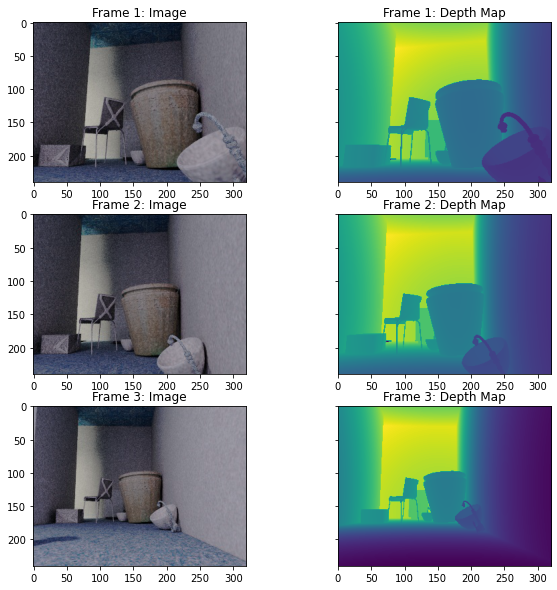

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(3, 2, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(10)

axes[0, 0].imshow(data_to_vis(image_1))
axes[0, 0].set_title('Frame 1: Image')

axes[0, 1].imshow(data_to_vis(depth_1))
axes[0, 1].set_title('Frame 1: Depth Map')

axes[1, 0].imshow(data_to_vis(image_2))
axes[1, 0].set_title('Frame 2: Image')

axes[1, 1].imshow(data_to_vis(depth_2))
axes[1, 1].set_title('Frame 2: Depth Map')

axes[2, 0].imshow(data_to_vis(image_3))
axes[2, 0].set_title('Frame 3: Image')

axes[2, 1].imshow(data_to_vis(depth_3))
axes[2, 1].set_title('Frame 3: Depth Map')
plt.show()

# Predict frame_2 using frame_3 and the depth of frame_2


### Predict using good estimated depth

In [ ]:
k_trans_j = pose_w_3 @ torch.inverse(j_pose_w)

predicted_frame_2 = kornia.geometry.warp_frame_depth(
    image_src=image_3,
    depth_dst=depth_2,
    src_trans_dst=k_trans_j,
    camera_matrix=intrinsics_2,
    normalize_points=True
)

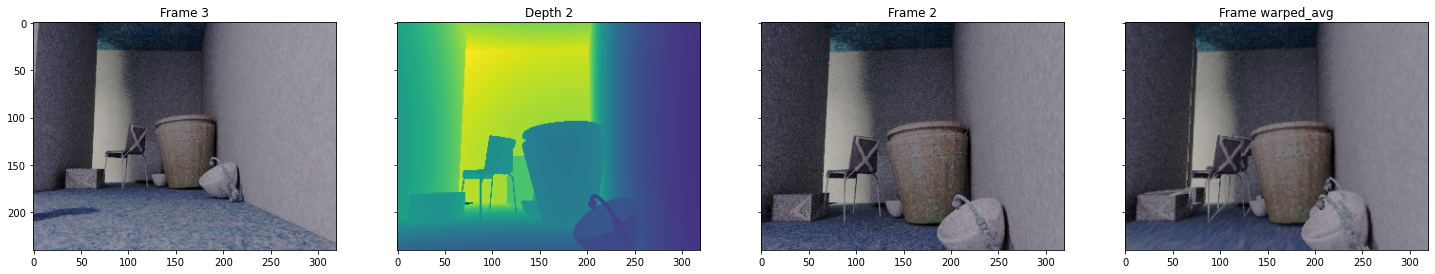

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1, 4, sharey=True)
fig.set_figheight(25)
fig.set_figwidth(25)

axes[0].imshow(data_to_vis(image_3))
axes[0].set_title('Frame 3')

axes[1].imshow(data_to_vis(depth_2))
axes[1].set_title('Predicted Depth 2')

axes[2].imshow(data_to_vis(image_2))
axes[2].set_title('Frame 2')

axes[3].imshow(data_to_vis(predicted_frame_2))
axes[3].set_title('Frame warped_avg')
plt.show()

In [ ]:
loss = torch.nn.L1Loss()
output = loss(image_2, predicted_frame_2)
output

tensor(0.0267)

### Predict with an incorrect depth

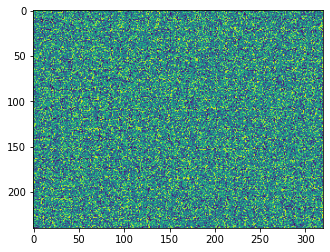

In [ ]:
bad_depth_2 = torch.rand(depth_1.shape)
plt.imshow(data_to_vis(bad_depth_2))
plt.show()

In [ ]:
k_trans_j = pose_w_3 @ torch.inverse(j_pose_w)

predicted_frame_2 = kornia.geometry.warp_frame_depth(
    image_src=image_3,
    depth_dst=bad_depth_2,
    src_trans_dst=k_trans_j,
    camera_matrix=intrinsics_2,
    normalize_points=True
)

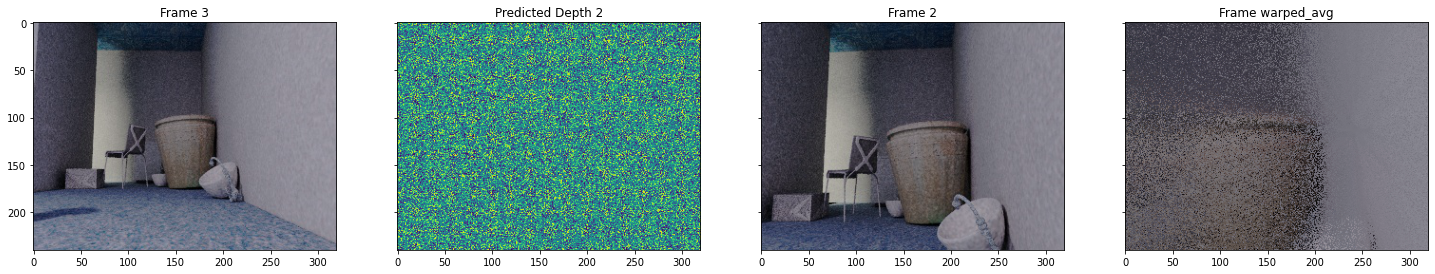

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1, 4, sharey=True)
fig.set_figheight(25)
fig.set_figwidth(25)

axes[0].imshow(data_to_vis(image_3))
axes[0].set_title('Frame 3')

axes[1].imshow(data_to_vis(bad_depth_2))
axes[1].set_title('Predicted Depth 2')

axes[2].imshow(data_to_vis(image_2))
axes[2].set_title('Frame 2')

axes[3].imshow(data_to_vis(predicted_frame_2))
axes[3].set_title('Frame warped_avg')
plt.show()

In [ ]:
loss = torch.nn.L1Loss()
output = loss(image_2, predicted_frame_2)
output

tensor(0.1047)